In [1]:
#Строим связь с базой данных
import psycopg2
import getpass

conn = psycopg2.connect(user='postgres',
                        database='postgres',
                        host='localhost',
                        port='5432',
                        password=getpass.getpass('Insert password: ')
)
print(conn.get_dsn_parameters())

Insert password: ········
{'user': 'postgres', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [4]:
#Для дальнейшей работы с базами данных необходимо скачать надстройку pandas
#для дальнейших заданий нам понядобятся даты присвоения рейтинга, их значения и индексы,а также тип рейтинга
import pandas as pd
import datetime
query="SELECT \"DATE_RAT\", \"RAT_ID\", \"GRADE\", \"CHANGE\", \"RAT_TYPE\", \"INN\", \"AGENCY_ID\" FROM ratings_task;"
data=pd.read_sql_query(query,conn)
data.head(10)
#print(data.dtypes)

,DATE_RAT,RAT_ID,GRADE,CHANGE,RAT_TYPE,INN,AGENCY_ID
0,2015-12-03,27,C++,понижен,FS&R,7718002769,EXP
1,2015-10-06,27,B+,понижен,FS&R,7718002769,EXP
2,2015-09-02,27,A,понижен,FS&R,7718002769,EXP
3,2015-03-05,27,A+,подтвержден,FS&R,7718002769,EXP
4,2014-03-26,27,A+,подтвержден,FS&R,7718002769,EXP
5,2013-02-25,27,A+,повышен,FS&R,7718002769,EXP
6,2011-12-09,27,A,подтвержден,FS&R,7718002769,EXP
7,2011-10-27,27,A,подтвержден,FS&R,7718002769,EXP
8,2011-10-18,27,A,подтвержден,FS&R,7718002769,EXP
9,2010-07-12,27,A,подтвержден,FS&R,7718002769,EXP


In [2]:
#Чтобы сформировать отчет, используем пункты, которые были составлены в ДЗ 3
#Создаем функцию, аргументы которой начало и конец временного индервала.
def my_fun(date1, date2):
    import pandas as pd
    import psycopg2
    import getpass
    conn = psycopg2.connect(user='postgres',
                        database='postgres',
                        host='localhost',
                        port='5432',
                        password=getpass.getpass('Insert password: ')
    )
    print(conn.get_dsn_parameters())
#Выгружаем все требуемые базы данных
    query1="SELECT * FROM scale_exp_task;"
    ranking=pd.read_sql_query(query1,conn)
    query4="SELECT \"DATE_RAT\", \"GRADE\", \"INN\", \"AGENCY_ID\" FROM ratings_task WHERE \"AGENCY_ID\" LIKE 'EXP';"
    company=pd.read_sql_query(query4,conn)
    query2="SELECT * FROM credit_events_task;"
    events=pd.read_sql_query(query2,conn)
    m=0
    len_company = max(company.index)
#Исключаем строки из получившейся базы данных, которые не удовлетворяют условиям дат
    for m in range(len_company):
        n=0
        if str(company[m-1:m].DATE_RAT.any()) >= str(date2):
            company.drop(m, axis=0, inplace = True)
        else:
            for n in range(m):
                if (company[m-1:m].INN.any() == company[n-1:n].INN.any()) and (str(company[m-1:m].DATE_RAT.any()) <= str(company[n-1:n].DATE_RAT.any())):
                    company.drop(m, axis=0, inplace = True)
                    break
    len_events = max(events.index)
    n=0 
#Считаем количество компаний, которые имели соответствующий ретйтинг
    for n in range(11):
        k=0
        dft=0
        for m in range(len_company):
                if ranking[n-1:n].GRADE.any() == company[m-1:m].GRADE.any(): 
                    k+=1
                    for i in range(len_events):
                        if (company[m-1:m].INN.any() == events[i-1:i].INN.any()) and (events[i-1:i].EVENT.any() == "dft") and (str(events[i-1:i].DATE_IVENT.any()) <= str(date2))and (str(events[i-1:i].DATE_IVENT.any()) >= str(date1)):
                            dft += 1
        ranking.loc[n, 'not_dft']= k
        ranking.loc[n, 'dft']= dft
#Считаем вероятность сохранения деятельности и веротяность дефолта компаний к концу периода для каждого рейтинга и записываем вероятности в отдельную колонку
        if k!=0:
            ranking.loc[n, 'prob_not_dft']= 1 - dft/k
            ranking.loc[n, 'prob_dft']= dft/k
        else:
            ranking.loc[n, 'prob_not_dft']= 0
            ranking.loc[n, 'prob_dft']= 0
    ranking.drop(12, axis=0, inplace = True)
    ranking.drop(11, axis=0, inplace = True)
#выводим новую получившуюся базу данных    
    return ranking
            

In [5]:
#вводим даты с клавиатуры
print('Введите дату начала периода')
print('Год')
Y1=int(input())
print('Месяц')
M1=int(input())
print('Дата')
D1=int(input())
print('Введите дату конца периода')
print('Год')
Y2=int(input())
print('Месяц')
M2=int(input())
print('Дата')
D2=int(input())
#Запускаем функцию и записываем в новую базу данных, которую затем выводим на экран
result = my_fun(datetime.date(Y1, M1, D1), datetime.date(Y2, M2, D2)) 
print(result)

Введите дату начала периода
Год
2017
Месяц
10
Дата
10
Введите дату конца периода
Год
2018
Месяц
12
Дата
12
Insert password: ········
{'user': 'postgres', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}
   GRADE  GRADE_ID  not_dft  dft  prob_not_dft  prob_dft
0    A++         0   4577.0  0.0           1.0       0.0
1     A+         1     64.0  0.0           1.0       0.0
2      A         2    102.0  0.0           1.0       0.0
3    B++         3    182.0  0.0           1.0       0.0
4     B+         4    101.0  0.0           1.0       0.0
5      B         5     22.0  0.0           1.0       0.0
6    C++         6      8.0  0.0           1.0       0.0
7     C+         7      2.0  0.0           1.0       0.0
8      C         8      2.0  0.0           1.0       0.0
9      D         9      0.0  0.0           0.0       0.0
10     E        10      0.0  0.0 

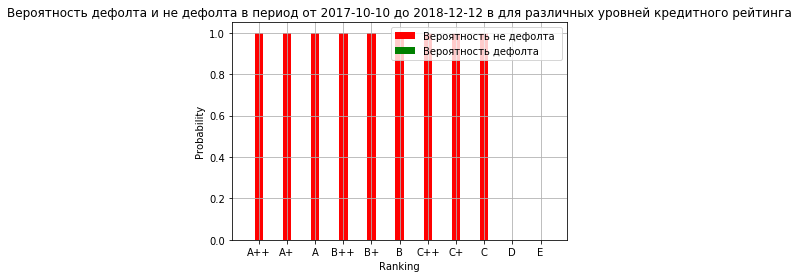

In [10]:
#Догружаем требуемую настройку и строим график
import matplotlib.pyplot as plt
data1=datetime.date(Y1, M1, D1)
data2=datetime.date(Y2, M2, D2)
plt.bar(result['GRADE'], result['prob_not_dft'], width = 0.3,  label = 'NOT_DFT', color = 'r')
plt.bar(result['GRADE'], result['prob_dft'], width = 0.8, label = 'DFT', color = 'g')

plt.xlabel('Ranking')
plt.ylabel('Probability')
plt.title('Вероятность дефолта и не дефолта в период от ' + str(data1) + ' до ' + str(data2) + ' в для различных уровней кредитного рейтинга')
plt.legend([ 'Вероятность не дефолта ', 'Вероятность дефолта'], frameon=True)
plt.grid()
#Важное дополнение в предыдущей домашней работе, это сохранение графика для дальнейшего использования
plt.savefig('Probability_dft.png')

In [13]:
#Для работы подгружаем все требуемые надстройки
from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os
env = Environment(loader=FileSystemLoader('.'))
#Соединяем с html файлом, в котором сохранен макет для будущего отчета. Файл должен находится в рабочей директории
template = env.get_template("myreport.html")
#формируем интересующий нас отчет
template_vars = {"title": "Попытка сформировать отчет",
                "INTRO": "Почему ничего нормально не работает? У меня какой-то медленный компьютер, это печально)", 
                 "TABLE_DESC": "Таблица. Распределение из дз 2, которая получается после функции за даты от "+str(data1)+ " до " + str(data2), 
                 "TABLE": result.to_html(), 
                 "IMAGE_DESC": "Рисунок. распределение вероятностей", 
                 "IMAGE": os.path.realpath('Probability_dft.png')
                }
html_out = template.render(template_vars, presentational_hints=True)
HTML(string=html_out).write_pdf('my_report.pdf', presentational_hints=True)